# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import statsmodels.api as sm
import shapely
import pysal as ps
import seaborn as sns
from matplotlib import colors

/Users/Xianbo/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
shape_path = "Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [4]:
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area = ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


## Explore CitiBike data

### Load CitiBike data

In [5]:
df_bike_monthly = DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

In [6]:
df_bike_monthly.sort_index(inplace = 1)
df_bike_monthly['spring'] = df_bike_monthly['summer'] = df_bike_monthly['autumn'] = df_bike_monthly['winter'] = 0
for i in range (0, len(df_bike_monthly.index)):
    month = df_bike_monthly.index[i].month
    if month >= 3 and month <= 5:
        df_bike_monthly['spring'][i] = 1
    elif month >= 6 and month <= 8:
        df_bike_monthly['summer'][i] = 1
    elif month >= 9 and month <= 11:
        df_bike_monthly['autumn'][i] = 1
    else:
        df_bike_monthly['winter'][i] = 1

In [7]:
df_bike_monthly_spring = df_bike_monthly[df_bike_monthly.spring == 1]
df_bike_monthly_summer = df_bike_monthly[df_bike_monthly.summer == 1]
df_bike_monthly_autumn = df_bike_monthly[df_bike_monthly.autumn == 1]
df_bike_monthly_winter = df_bike_monthly[df_bike_monthly.winter == 1]

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [8]:
station_id = DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index = station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [9]:
# combine lat and lon to one column
station_id['lonlat'] = zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry'] = station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [10]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010'] = a

% 100.


In [11]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [12]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve_Summer']=df_bike_monthly_summer.sum()
station_id['MonthlyAve_Winter']=df_bike_monthly_winter.sum()

In [13]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve_Summer,MonthlyAve_Winter
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,22422,9456
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,32869,11373
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,87375,36543
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,33018,14170
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,59890,21889


### Add the monthly average rides to the CT shapefile 

In [14]:
temp_Summer = station_id[['MonthlyAve_Summer']]
temp_Summer['station_id'] = station_id.index
temp_Summer.index=station_id['BoroCT2010']
ct_shape_MonthlyAve_Summer = ct_shape.join(temp_Summer)
ct_shape_MonthlyAve_Summer.fillna(0,inplace = True)

/Users/Xianbo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [15]:
temp_Winter = station_id[['MonthlyAve_Winter']]
temp_Winter['station_id'] = station_id.index
temp_Winter.index=station_id['BoroCT2010']
ct_shape_MonthlyAve_Winter = ct_shape.join(temp_Winter)
ct_shape_MonthlyAve_Winter.fillna(0,inplace=True)

/Users/Xianbo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


/Users/Xianbo/anaconda/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


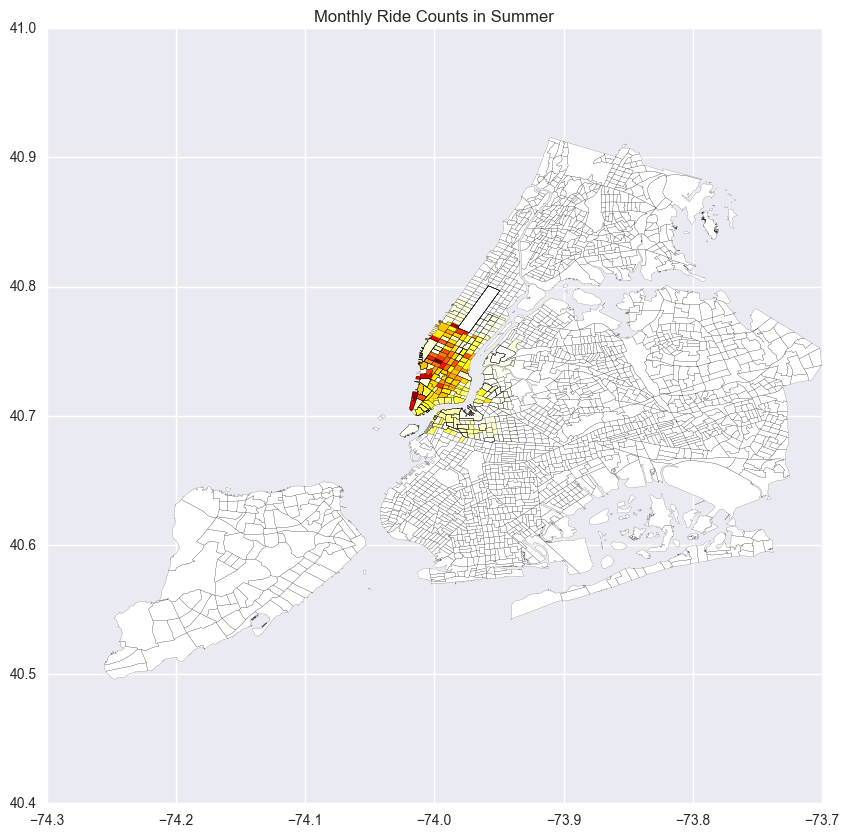

In [16]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve_Summer.plot(column = 'MonthlyAve_Summer',colormap = 'hot_r',alpha = 1,linewidth = 0.1,ax = ax)
plt.title("Monthly Ride Counts in Summer")

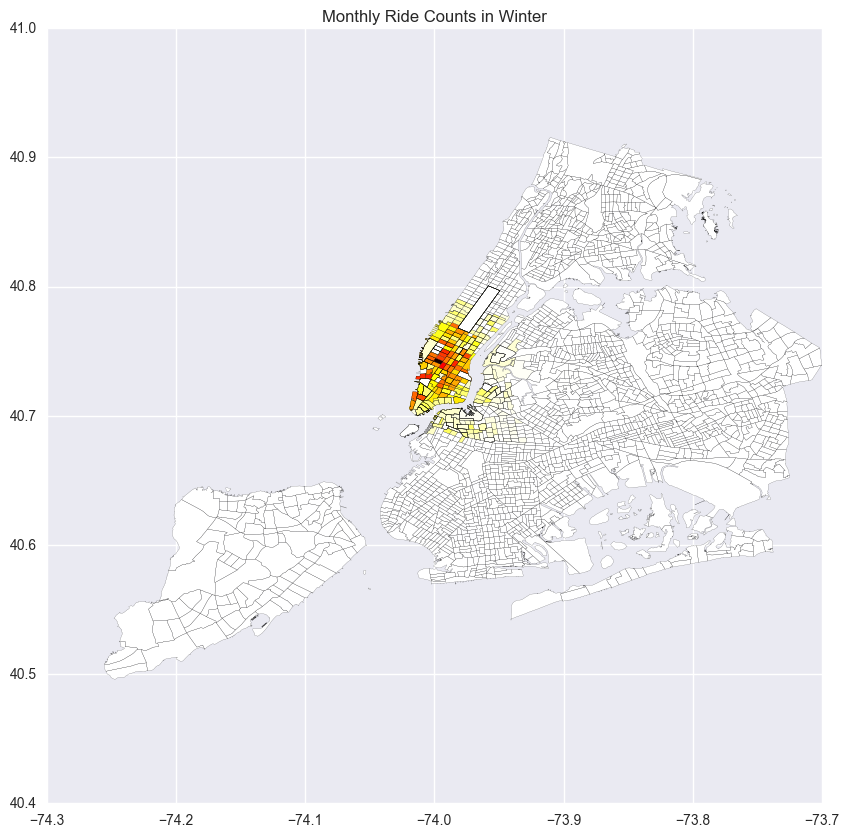

In [17]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve_Winter.plot(column = 'MonthlyAve_Winter',colormap = 'hot_r',alpha = 1,linewidth = 0.1,ax = ax)
plt.title("Monthly Ride Counts in Winter")

### Removing the CTs that are out of zoom boundries

In [18]:
ct_shape_MonthlyAve_Zoom_Summer=(ct_shape_MonthlyAve_Summer[ct_shape_MonthlyAve_Summer
                                 .centroid
                                 .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [19]:
ct_shape_MonthlyAve_Zoom_Winter=(ct_shape_MonthlyAve_Winter[ct_shape_MonthlyAve_Winter
                                 .centroid
                                 .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [20]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs in summer:", len(temp_Summer.MonthlyAve_Summer)
print "Number of zoomed CTs in winter:", len(temp_Winter.MonthlyAve_Winter)

Total number of CTs: 2166
Number of zoomed CTs in summer: 543
Number of zoomed CTs in winter: 543


### Map the monthly rides 

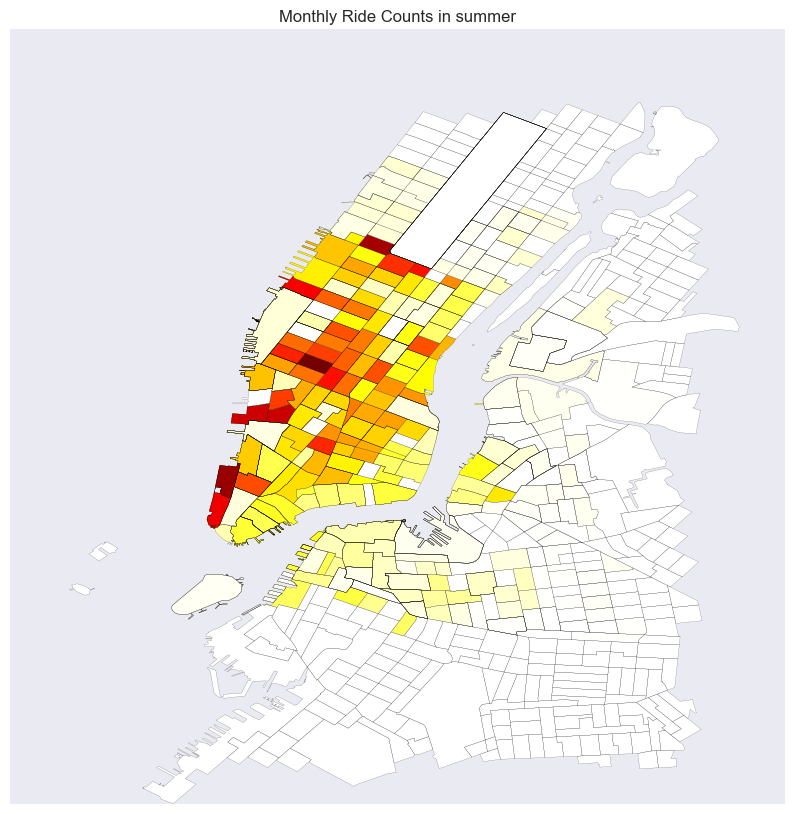

In [21]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom_Summer.plot(column = 'MonthlyAve_Summer',colormap = 'hot_r',alpha = 1,linewidth = 0.1,ax = ax)
plt.title("Monthly Ride Counts in summer")

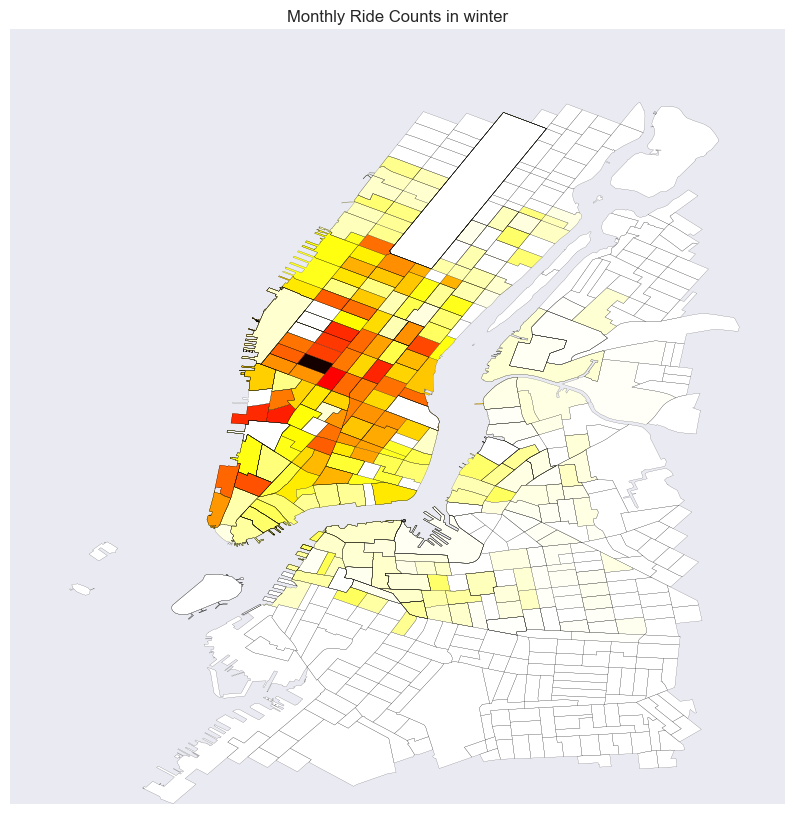

In [22]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom_Winter.plot(column = 'MonthlyAve_Winter',colormap = 'hot_r',alpha = 1,linewidth = 0.1,ax = ax)
plt.title("Monthly Ride Counts in winter")

### Export Shapefile CTs in the CitiBike Zone

In [23]:
path = 'Output/ct_shape_MonthlyAve_Zoom.shp'

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [24]:
qW_CT = ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [25]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [26]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [27]:
Wmatrix, ids = qW_CT.full()

In [28]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [29]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [30]:
MonthlyRide_Summer = ct_shape_MonthlyAve_Zoom_Summer.MonthlyAve_Summer
MonthlyRideLag_Summer = ps.lag_spatial(qW_CT, MonthlyRide_Summer)
MonthlyRide_Winter = ct_shape_MonthlyAve_Zoom_Winter.MonthlyAve_Winter
MonthlyRideLag_Winter = ps.lag_spatial(qW_CT, MonthlyRide_Winter)

#### Create Quantiles for maping

In [31]:
MonthlyRideLagQ10_Summer = ps.Quantiles(MonthlyRideLag_Summer, k=10)
MonthlyRideLagQ10_Summer

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    49.286                 2
   49.286 < x[i] <=   882.900                78
  882.900 < x[i] <=  2346.833                80
 2346.833 < x[i] <=  5645.067                84
 5645.067 < x[i] <=  8593.933                75
 8593.933 < x[i] <= 19189.030                79
19189.030 < x[i] <= 27831.071                80
27831.071 < x[i] <= 32327.735                79
32327.735 < x[i] <= 49147.643                80

In [32]:
MonthlyRideLagQ10_Winter = ps.Quantiles(MonthlyRideLag_Winter, k=10)
MonthlyRideLagQ10_Winter

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    36.286                 2
   36.286 < x[i] <=   603.729                78
  603.729 < x[i] <=  1458.923                80
 1458.923 < x[i] <=  2284.227                79
 2284.227 < x[i] <=  3278.714                80
 3278.714 < x[i] <=  7763.237                79
 7763.237 < x[i] <= 10456.870                80
10456.870 < x[i] <= 12783.385                79
12783.385 < x[i] <= 20551.286                80

#### Map the monthly rides lag

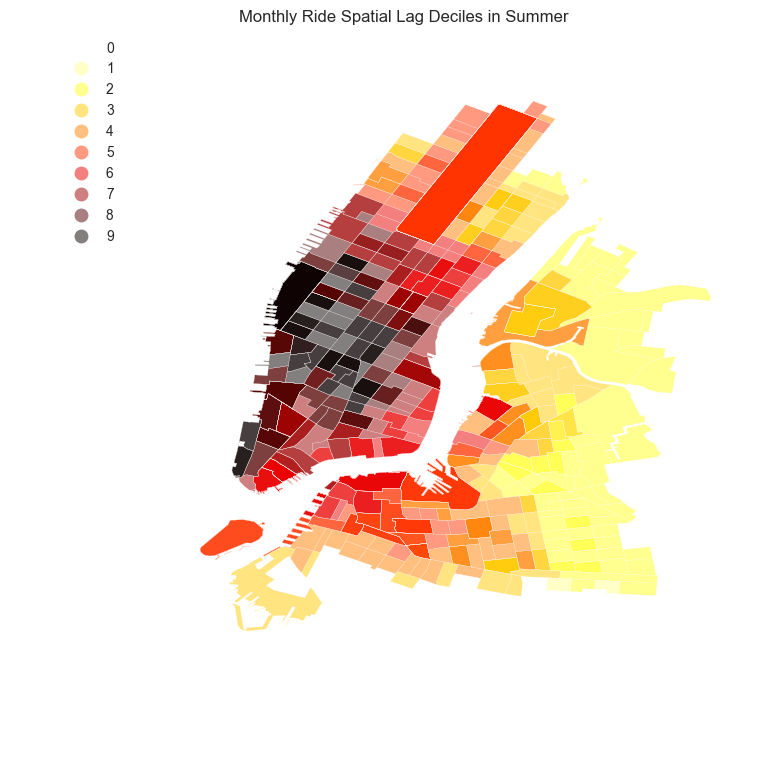

In [33]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom_Summer.assign(cl = MonthlyRideLagQ10_Summer.yb).plot(column = 'cl', categorical = True, 
        k = 10, cmap = 'hot_r', linewidth = 0.1, ax = ax, 
        edgecolor = 'white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles in Summer")


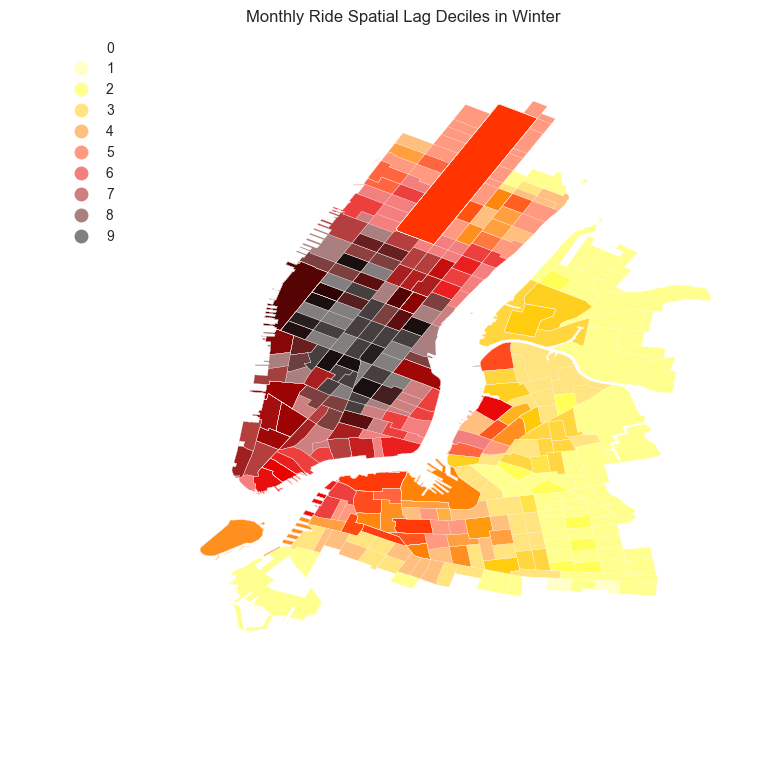

In [34]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom_Winter.assign(cl = MonthlyRideLagQ10_Winter.yb).plot(column = 'cl', categorical = True, 
        k = 10, cmap = 'hot_r', linewidth = 0.1, ax = ax, 
        edgecolor = 'white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles in Winter")


## Global  Spatial Autocorrelation

### Autocorrelation in summer

In [35]:
b,a = np.polyfit(MonthlyRide_Summer, MonthlyRideLag_Summer, 1)
b,a 

(0.64335490815356489, 4220.5552980795646)

### Autocorrelation in winter

In [36]:
b,a = np.polyfit(MonthlyRide_Winter, MonthlyRideLag_Winter, 1)
b,a 

(0.66023249858156818, 1600.832423867588)

### Moran Scatterplot in Summer

In [37]:
def Moranplot (MonthlyRide, MonthlyRideLag):
    f, ax = plt.subplots(1, figsize=(9, 9))

    plt.plot(MonthlyRide, MonthlyRideLag, '.', color='firebrick')

    # dashed vert at mean of the last year's PCI
    plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle = '--')
    # dashed horizontal at mean of lagged PCI
    plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle = '--')

    # red line of best fit using global I as slope
    plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
    plt.ylabel('Spatial Lag of MonthlyRides')
    plt.xlabel('MonthlyRides')

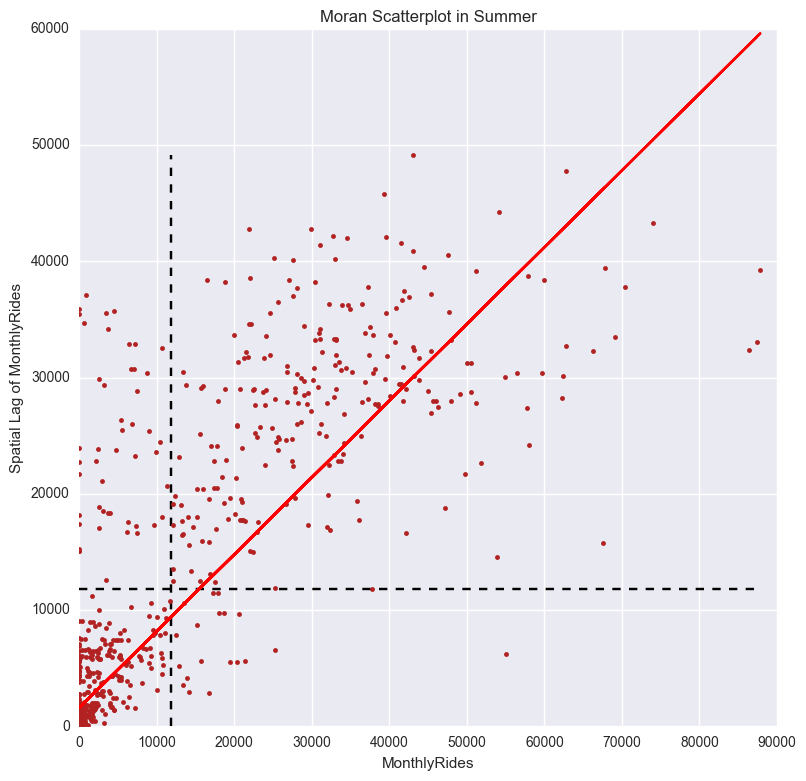

In [38]:
Moranplot(MonthlyRide_Summer, MonthlyRideLag_Summer)
plt.title('Moran Scatterplot in Summer')

### Moran Scatterplot in Winter

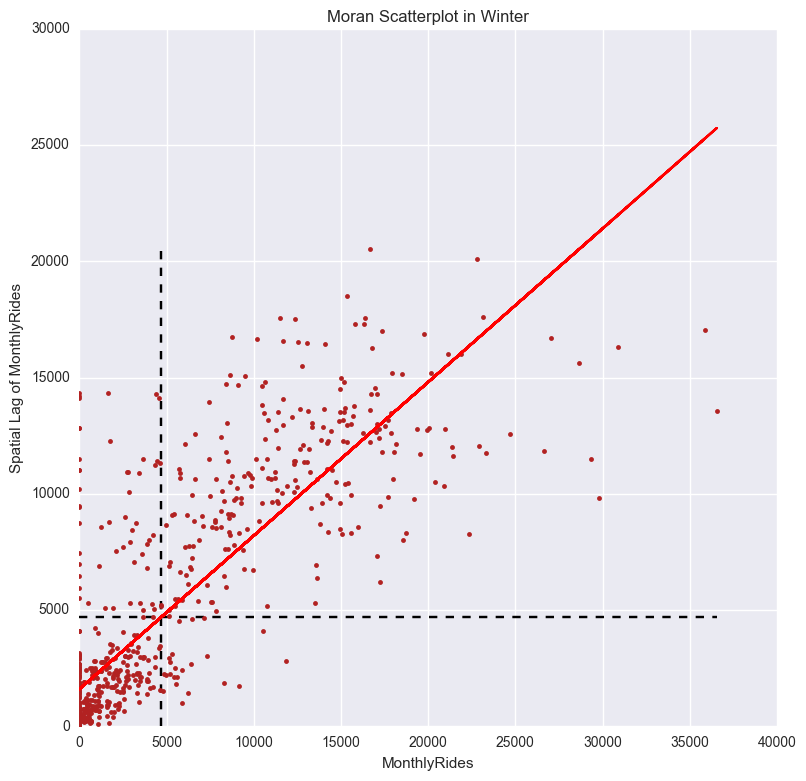

In [39]:
Moranplot(MonthlyRide_Winter, MonthlyRideLag_Winter)
plt.title('Moran Scatterplot in Winter')

### Moran's I

In [40]:
I_MonthlyRide_Summer = ps.Moran(MonthlyRide_Summer, qW_CT)

In [41]:
I_MonthlyRide_Summer.I, I_MonthlyRide_Summer.p_sim

(0.64353398667011008, 0.001)

In [42]:
I_MonthlyRide_Winter = ps.Moran(MonthlyRide_Winter, qW_CT)

In [43]:
I_MonthlyRide_Winter.I, I_MonthlyRide_Winter.p_sim

(0.66039156431885593, 0.001)

Thus, the $I$ statistic is $0.64$ for Summer and $0.66$ for Winter, and has a very small $p$ value. 

In [44]:
I_MonthlyRide_Summer.sim[0:10]

array([ 0.01385393,  0.00956614, -0.01272269,  0.01209416, -0.0152332 ,
       -0.02129998, -0.00703186, -0.00740311, -0.01563288,  0.00187485])

In [45]:
I_MonthlyRide_Winter.sim[0:10]

array([-0.01875102, -0.00405474,  0.01586099, -0.02170543,  0.00793553,
        0.01634044,  0.02084717, -0.01266169, -0.01179445, -0.01515466])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [46]:
plt.rcParams['figure.figsize'] = (14,3)

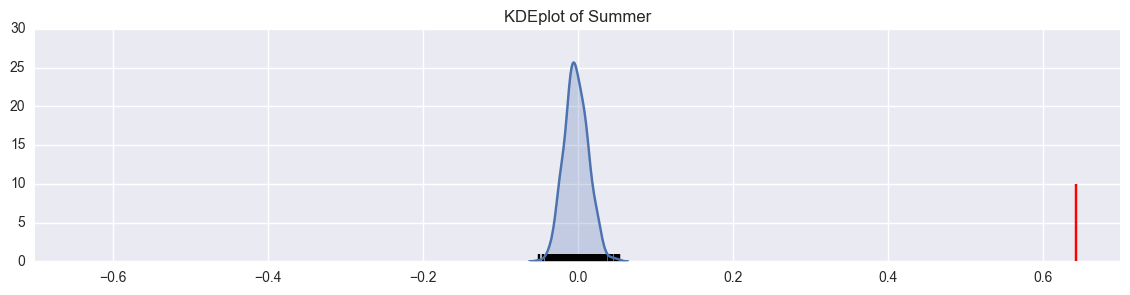

In [47]:
sns.kdeplot(I_MonthlyRide_Summer.sim, shade = True)
plt.vlines(I_MonthlyRide_Summer.sim, 0, 1)
plt.vlines(I_MonthlyRide_Summer.I, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('KDEplot of Summer')

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

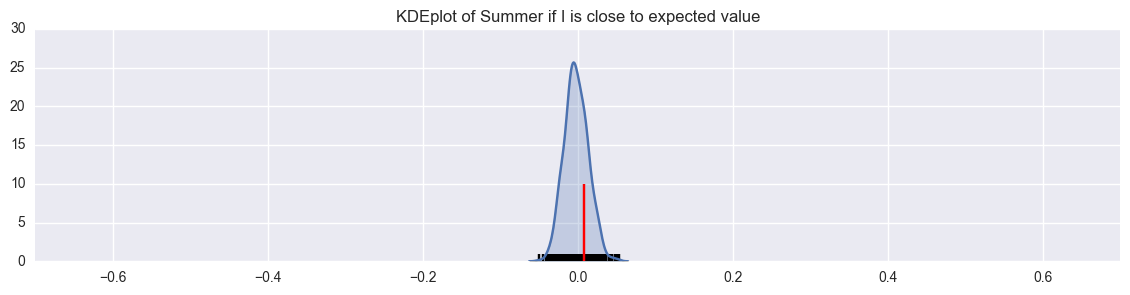

In [48]:
sns.kdeplot(I_MonthlyRide_Summer.sim, shade = True)
plt.vlines(I_MonthlyRide_Summer.sim, 0, 1)
plt.vlines(I_MonthlyRide_Summer.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('KDEplot of Summer if I is close to expected value')

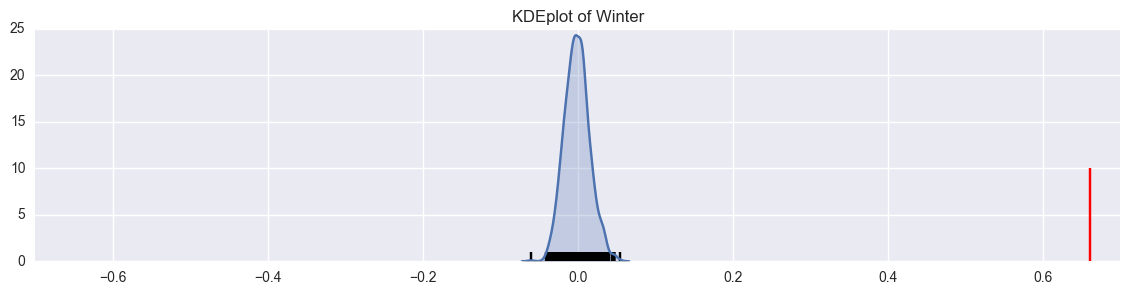

In [49]:
sns.kdeplot(I_MonthlyRide_Winter.sim, shade = True)
plt.vlines(I_MonthlyRide_Winter.sim, 0, 1)
plt.vlines(I_MonthlyRide_Winter.I, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('KDEplot of Winter')

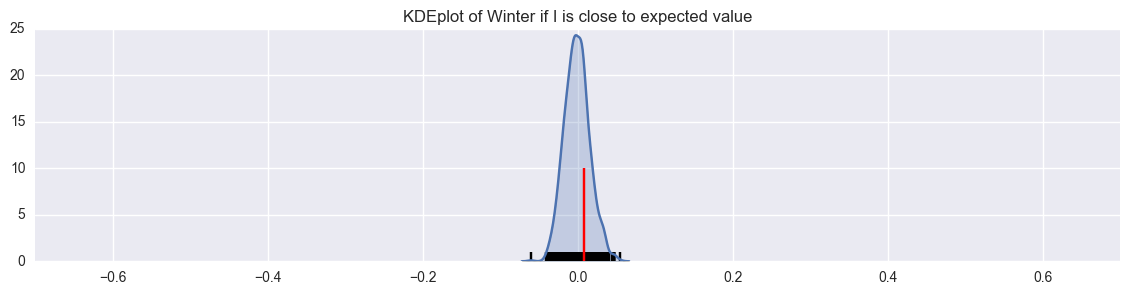

In [50]:
sns.kdeplot(I_MonthlyRide_Winter.sim, shade=True)
plt.vlines(I_MonthlyRide_Winter.sim, 0, 1)
plt.vlines(I_MonthlyRide_Winter.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('KDEplot of Winter if I is close to expected value')

## Local  Spatial Autocorrelation

In [51]:
LMo_MonthlyRide_Summer = ps.Moran_Local(MonthlyRide_Summer, qW_CT,permutations=999)
LMo_MonthlyRide_Winter = ps.Moran_Local(MonthlyRide_Winter, qW_CT,permutations=999)

In [52]:
LMo_MonthlyRide_Summer.Is[0:5], LMo_MonthlyRide_Summer.p_sim[0:5]

(array([-0.        , -0.2391325 ,  0.01474643,  0.00173718,  0.02473794]),
 array([ 0.001,  0.21 ,  0.379,  0.36 ,  0.361]))

In [53]:
LMo_MonthlyRide_Winter.Is[0:5], LMo_MonthlyRide_Winter.p_sim[0:5]

(array([ -0.00000000e+00,  -3.14119985e-01,  -1.93084894e-04,
         -4.03594530e-03,  -7.97531288e-02]),
 array([ 0.001,  0.139,  0.46 ,  0.479,  0.399]))

In [54]:
# the autocorrelation in winter is larger than that of summer. So the in winter the rides have more relationship.

### LISA (Local Indicators of Spatial Autocorrelation)

In [55]:
sigs_Summer = MonthlyRide_Summer[LMo_MonthlyRide_Summer.p_sim <= .001]
W_sigs_Summer = MonthlyRideLag_Summer[LMo_MonthlyRide_Summer.p_sim <= .001]
insigs_Summer = MonthlyRide_Summer[LMo_MonthlyRide_Summer.p_sim > .001]
W_insigs_Summer = MonthlyRideLag_Summer[LMo_MonthlyRide_Summer.p_sim > .001]

In [56]:
sigs_Winter = MonthlyRide_Winter[LMo_MonthlyRide_Winter.p_sim <= .001]
W_sigs_Winter = MonthlyRideLag_Winter[LMo_MonthlyRide_Winter.p_sim <= .001]
insigs_Winter = MonthlyRide_Winter[LMo_MonthlyRide_Winter.p_sim > .001]
W_insigs_Winter = MonthlyRideLag_Winter[LMo_MonthlyRide_Winter.p_sim > .001]

### Plot Signficant LISA

In [57]:
def lisaplot (MonthlyRide, MonthlyRideLag, sigs, W_sigs, insigs, W_insigs, I_MonthlyRide):
    f, ax = plt.subplots(figsize = (9, 9))
    plt.plot(sigs, W_sigs, '.', color = 'firebrick')
    plt.plot(insigs, W_insigs, '.k', alpha = .2)
    plt.text(s='$I = %.3f$' % I_MonthlyRide.I, x = 120000, y = 5000, fontsize = 18)

     # dashed vert at mean of the last year's PCI
    plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle = '--')
     # dashed horizontal at mean of lagged PCI
    plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle = '--')

    # red line of best fit using global I as slope
    plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
    plt.ylabel('Spatial Lag of MonthlyRides')
    plt.xlabel('MonthlyRides')

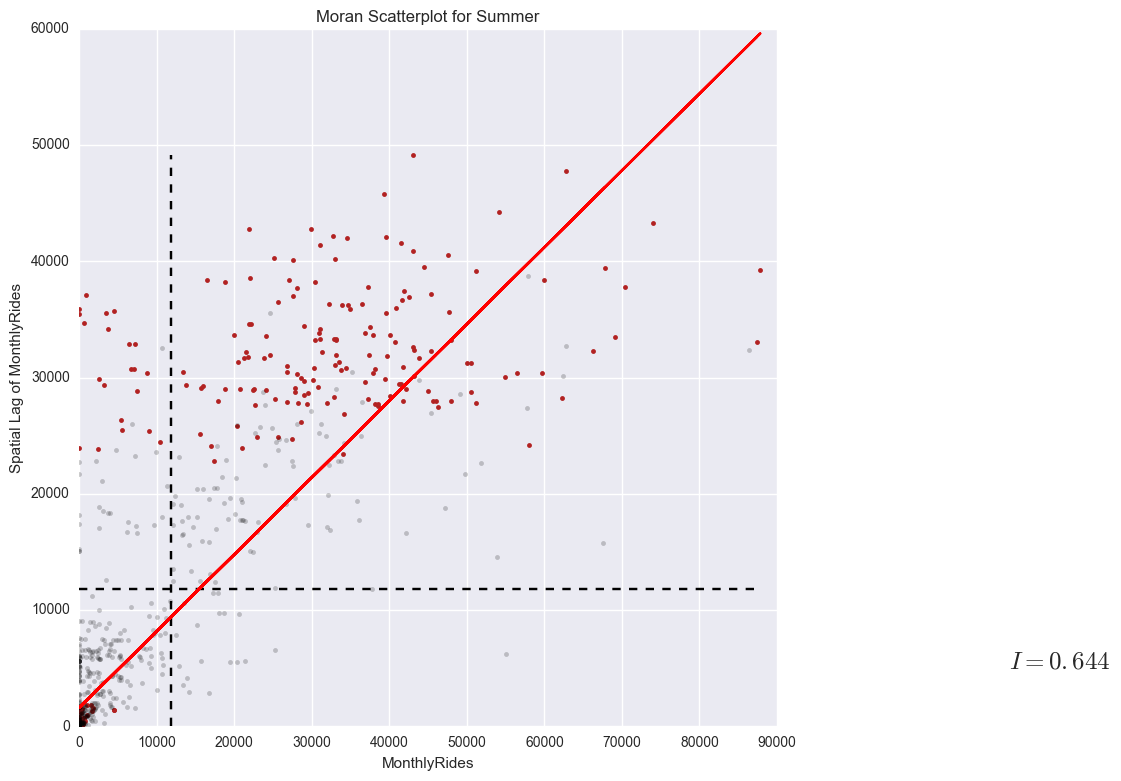

In [58]:
lisaplot(MonthlyRide_Summer, MonthlyRideLag_Summer, sigs_Summer, W_sigs_Summer, insigs_Summer,
         W_insigs_Summer, I_MonthlyRide_Summer)
plt.title('Moran Scatterplot for Summer')

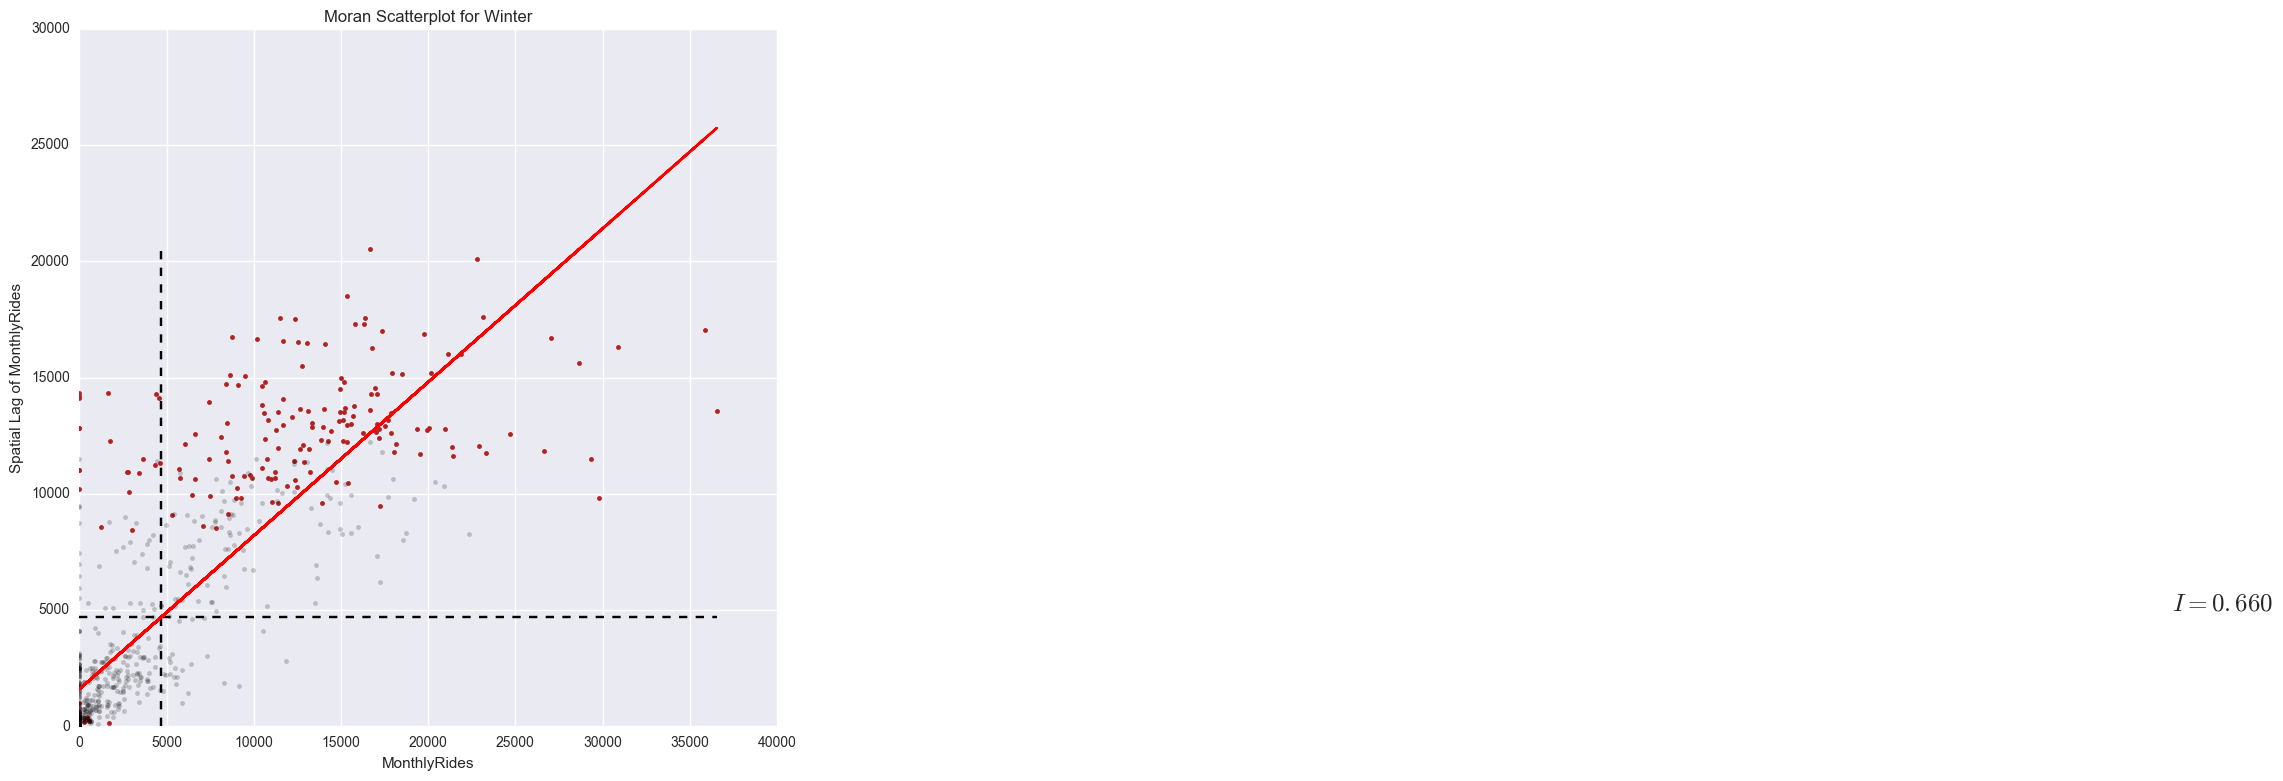

In [59]:
lisaplot(MonthlyRide_Winter, MonthlyRideLag_Winter, sigs_Winter, W_sigs_Winter, insigs_Winter,
         W_insigs_Winter, I_MonthlyRide_Winter)
plt.title('Moran Scatterplot for Winter')

### Hot and Cold spots 

In [60]:
sig_Summer = LMo_MonthlyRide_Summer.p_sim < 0.01
hotspots_Summer = LMo_MonthlyRide_Summer.q == 1 * sig_Summer 
coldspots_Summer = LMo_MonthlyRide_Summer.q == 3 * sig_Summer 
sig_Winter = LMo_MonthlyRide_Summer.p_sim < 0.01
hotspots_Winter = LMo_MonthlyRide_Summer.q == 1 * sig_Winter
coldspots_Winter = LMo_MonthlyRide_Summer.q == 3 * sig_Winter
print "Number of Hotspots in Summer:", hotspots_Summer.sum()
print "Number of Coldspots in Summer:", coldspots_Summer.sum()
print "Number of Hotspots in Winter:", hotspots_Winter.sum()
print "Number of Coldspots in Winter:", coldspots_Winter.sum()

Number of Hotspots in Summer: 189
Number of Coldspots in Summer: 239
Number of Hotspots in Winter: 189
Number of Coldspots in Winter: 239


In [61]:
def hcplot(hotspots, coldspots, ct_shape_MonthlyAve_Zoom):
    hcmap = colors.ListedColormap(['grey','red','blue'])
    hotcold = hotspots*1 + coldspots*2

    f, ax = plt.subplots(figsize = (9, 9))
    ct_shape_MonthlyAve_Zoom.assign(cl = hotcold).plot(column = 'cl', categorical=True, 
    k = 10, cmap = hcmap, linewidth = 0.1, ax = ax, 
    edgecolor = 'white', legend = True)
    ax.set_axis_off()

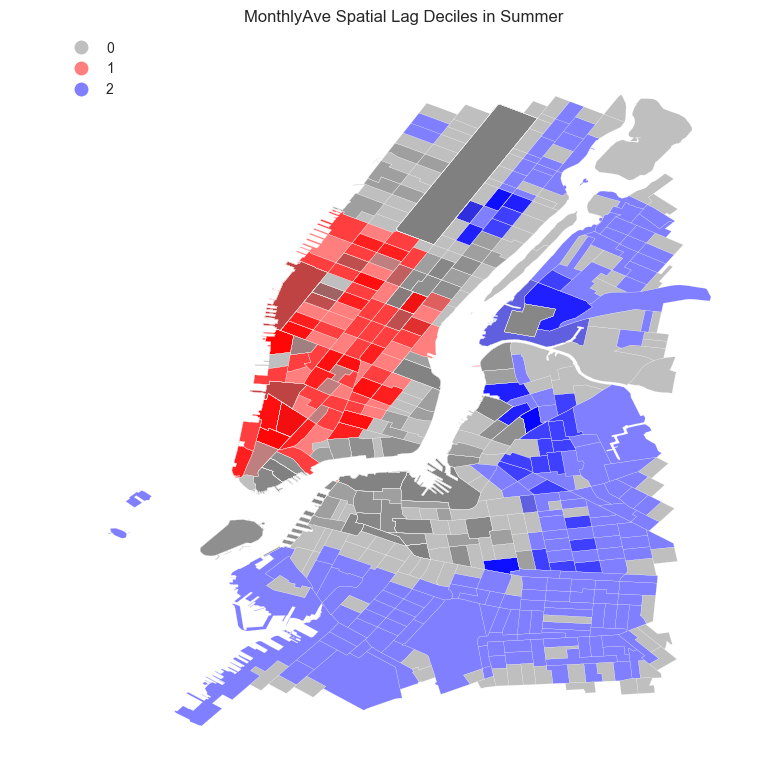

In [62]:
hcplot(hotspots_Summer, coldspots_Summer, ct_shape_MonthlyAve_Zoom_Summer)
plt.title("MonthlyAve Spatial Lag Deciles in Summer")

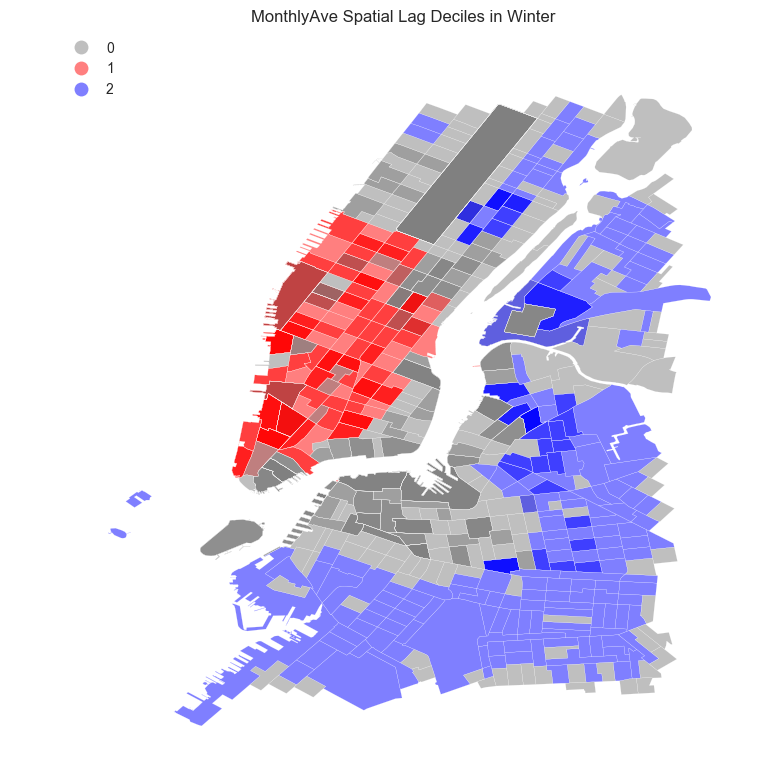

In [63]:
hcplot(hotspots_Winter, coldspots_Winter, ct_shape_MonthlyAve_Zoom_Winter)
plt.title("MonthlyAve Spatial Lag Deciles in Winter")